# Bike Sharing Demand

## CRISP-DM Approach

CRISP-DM stands for Cross-Industry Standard Process for Data Mining and describes a structured approach to understanding, preparing, modeling and evaluating data. This process includes the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Deployment is not relevant for this type of project, as I won't be deploying my model to a web server. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

### 2. Data Understanding

The data set is similar to the bike sharing dataset provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). However, the aforementioned dataset only contains data for 2011 and 2012. It was originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). 

To have a larger dataset, I collected the following data from the following sources for the time period of January 1, 2011 until December 31, 2018:
* The bike demand data comes from [Capital Bike Share](http://capitalbikeshare.com/system-data)
* The weather data was taken from [NOAA's National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/search)
* The holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). 

The dataset uses data from the bike sharing stations of Capital Bike Share in Washington, D.C., USA. The weather data and holiday data refer to the same location.


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, pearsonr
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin



import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


#### 2.1. Loading the data and visualizing and describing it

In [2]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike_sharing_dataset.csv')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,cluster,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,46.0,90.0,136.0,NaN
1,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,86.0,111.0,197.0,NaN
2,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.0,9.0,30.0,39.0,NaN
3,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.0,0.0,3.0,3.0,NaN
4,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,0.0,1.0,1.0,NaN


In [3]:
# print descriptive statistics
bike_df.describe()


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,...,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,cluster,casual,registered,total_cust,holiday
count,39401.000000,48664.000000,48664.000000,48664.000000,48664.000000,48664.000000,25084.0,3444.0,11716.0,2026.0,...,943.0,405.0,110.0,40.0,12.0,48660.000000,48660.000000,48660.000000,48660.000000,1462.0
mean,14.593688,8.761589,19.245102,11.289880,3.443951,3.166839,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,11.560666,100.581299,362.035347,462.616646,1.0
std,9.449835,9.427189,9.738761,9.411256,8.170975,1.369183,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.057284,281.081989,585.737100,789.663643,0.0
min,-12.100000,-16.993750,-7.980000,-15.658333,0.000000,0.375000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.000000,1.0
25%,6.766667,0.816667,11.376923,3.427273,0.004167,2.200000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,5.000000,2.000000,13.000000,16.000000,1.0
50%,15.566667,8.925000,20.294471,12.075000,0.256842,2.900000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,11.000000,10.000000,73.000000,87.000000,1.0
75%,23.133333,17.538462,27.960000,19.950000,2.836458,3.875000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,17.000000,55.000000,391.000000,455.000000,1.0
max,31.733333,26.206250,37.850000,28.666667,118.789796,12.750000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,25.000000,4637.000000,4058.000000,6848.000000,1.0


In [4]:
# check the datatypes of each variable
bike_df.dtypes


date                  object
temp_avg             float64
temp_min             float64
temp_max             float64
temp_observ          float64
precip               float64
wind                 float64
wt_fog               float64
wt_heavy_fog         float64
wt_thunder           float64
wt_sleet             float64
wt_hail              float64
wt_glaze             float64
wt_haze              float64
wt_drift_snow        float64
wt_high_wind         float64
wt_mist              float64
wt_drizzle           float64
wt_rain              float64
wt_freeze_rain       float64
wt_snow              float64
wt_ground_fog        float64
wt_ice_fog           float64
wt_freeze_drizzle    float64
wt_unknown           float64
cluster              float64
casual               float64
registered           float64
total_cust           float64
holiday              float64
dtype: object

Based on the source repository of the data set, these are the meanings of each variable:
- date: date
- temp_avg: average temperature in Celcius
- temp_min: minimum temperature in Celcius
- temp_max: maximum temperature in Celcius
- temp_observ: temperature at time of observation
- precip: precipitation in mm 
- wind: average windspeed
- wt: weather types
    - fog: fog, ice fog, or freezing fog (may include heavy fog)
    - heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
    - thunder: thunder
    - sleet: ice pellets, sleet, snow pellets, or small hail
    - hail: hail (may include small hail)
    - glaze: glaze or rime
    - haze: smoke or haze
    - drift_snow: blowing or drifting snow 
    - high_wind: high or damaging winds
    - mist: mist
    - drizzle: drizzle
    - rain: rain (may include freezing rain, drizzle, and freezing drizzle)
    - freeze_rain: freezing rain
    - snow: snow, snow pellets, snow grains, or ice crystals
    - ground_fog: ground fog
    - ice_fog: ice for or freezing fog
    - freeze_drizzle: freezing drizzle
    - unknown: unknown source of precipitation
- casual: count of casual users
- registered: count of registered users
- total_cust: count of total rental bikes including both casual and registered
- holiday: holiday in Washington D.C.


##### Checking for and dealing with missing values

In [5]:
# Check for missing values
bike_df.isnull().sum()


date                     0
temp_avg              9263
temp_min                 0
temp_max                 0
temp_observ              0
precip                   0
wind                     0
wt_fog               23580
wt_heavy_fog         45220
wt_thunder           36948
wt_sleet             46638
wt_hail              47908
wt_glaze             46231
wt_haze              37699
wt_drift_snow        48582
wt_high_wind         44420
wt_mist              44489
wt_drizzle           47242
wt_rain              44097
wt_freeze_rain       48615
wt_snow              47721
wt_ground_fog        48259
wt_ice_fog           48554
wt_freeze_drizzle    48624
wt_unknown           48652
cluster                  4
casual                   4
registered               4
total_cust               4
holiday              47202
dtype: int64

The feature **temp_avg** is missing 821 values. I will use the temp_min, temp_max and temp_observ features to estimate the missing temp_avg values. There are also 4 values missing for **casual, registered and total_cust features** and the target, respectively. I will check why these are missing and exclude those observations because if the target variable is missing, I cannot estimate it. 

The **holiday** feature has NAs but these should actually 0s, which I will convert. The **wt_** features also have NAs where 0s should be which I will insert.


In [6]:
# fill NAs with 0 where applicable
wt_feats = [x for x in bike_df.columns if 'wt' in x]
bike_df['holiday'] = bike_df['holiday'].fillna(0)
bike_df[wt_feats] = bike_df[wt_feats].fillna(0)


There seem to be four days where no data was captured for the rented bikes. Because this is a time series, I am not sure whether I can drop these rows or whether I should interpolate the target values for these four days. More research is necessary to determine this.

In [7]:
# check casual, registered and total_cust missing rows
missing_target = bike_df[bike_df['total_cust'].isna()]
missing_target


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,cluster,casual,registered,total_cust,holiday
26146,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
26147,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
26148,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
26149,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [8]:
# create list that includes missing dates for all clusters
multiple_num = [x for x in range(26)]

missing_total_cust_cluster = pd.DataFrame()

for multiple in multiple_num:
    missing_total_cust = bike_df[bike_df['total_cust'].isna()]
    missing_total_cust['cluster'] = multiple
    missing_total_cust.fillna(value={'total_cust': -1, 'casual': -1, 'registered': -1}, inplace=True)
    missing_total_cust_cluster = missing_total_cust_cluster.append(missing_total_cust)

missing_total_cust_cluster


C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\julia\Anaconda3\lib\site-packages\pandas\core\generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,cluster,casual,registered,total_cust,holiday
26146,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,-1.0,-1.0,-1.0,0.0
26147,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,-1.0,-1.0,-1.0,0.0
26148,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,-1.0,-1.0,-1.0,0.0
26149,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,-1.0,-1.0,-1.0,0.0
26146,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.0
26147,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.0
26148,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.0
26149,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,-1.0,-1.0,0.0
26146,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2,-1.0,-1.0,-1.0,0.0
26147,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,-1.0,-1.0,-1.0,0.0


In [9]:
# add the -1 total_cust values for each cluster to the overall bike_df dataframe
bike_df = bike_df.append(missing_total_cust_cluster, ignore_index=True)
bike_df.sort_values(by=['date'], inplace=True)
bike_df.reset_index(drop=True, inplace=True)

# there are still the original missing values included in this dataframe
# I will drop these four columns
bike_df.dropna(subset=['total_cust'], axis='rows', inplace=True)
bike_df


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,cluster,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,46.0,90.0,136.0,0.0
1,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,86.0,111.0,197.0,0.0
2,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,9.0,30.0,39.0,0.0
3,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,3.0,3.0,0.0
4,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,1.0,0.0
5,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,11.0,11.0,22.0,0.0
6,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17.0,89.0,292.0,381.0,0.0
7,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.0,3.0,20.0,23.0,0.0
8,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.0,85.0,70.0,155.0,0.0
9,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.0,34.0,72.0,106.0,0.0


There are also 'missing' entries for some dates where no bike was rented at certain stations. These entries should be added with total_cust as 0.

In [10]:
# creating dataframe that only contains the weather for all dates
only_weather_df = bike_df.drop(columns=['cluster', 'total_cust', 'casual', 'registered'])
only_weather_df.drop_duplicates(inplace=True)
only_weather_df


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925000,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,2011-01-06,NaN,-4.993333,4.233333,-4.245455,0.000000,1.600000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58,2011-01-07,NaN,-3.885714,2.857143,-1.570000,0.101205,2.550000,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
67,2011-01-08,NaN,-3.980000,0.486667,-2.472727,0.285057,4.575000,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
76,2011-01-09,NaN,-6.293333,0.226667,-6.072727,0.283529,6.425000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2011-01-10,NaN,-6.238462,0.507692,-5.177778,0.000000,2.975000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# for loop to create time series for all different clusters
cluster_num = [x for x in range(26)]
remove_cols = list(bike_df.columns[1:-5])
remove_cols.append('holiday')

all_clusters_dict = defaultdict()

for cluster in cluster_num:
    cluster_val = bike_df.loc[bike_df['cluster'] == cluster]
    
    cluster_val.drop(columns=remove_cols, axis=1, inplace=True)
    cluster_val_df = cluster_val.merge(only_weather_df, how='right', on='date')
    cluster_val_df.sort_values(by=['date'], inplace=True)
    column_names = cluster_val_df.columns
    
    all_clusters_dict[cluster] = cluster_val_df


C:\Users\julia\Anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# replacing remaining missing values for each cluster with 0 and the number of cluster
fillna_list = ['casual', 'registered', 'total_cust']

for key, val in all_clusters_dict.items():
    val['cluster'].fillna(key, inplace=True)
    for item in fillna_list:
        val[item].fillna(0, inplace=True)
    

In [13]:
# create separate dataframes for all clusters
cluster0 = pd.DataFrame(data=all_clusters_dict[0], columns=column_names)
cluster1 = pd.DataFrame(data=all_clusters_dict[1], columns=column_names)
cluster2 = pd.DataFrame(data=all_clusters_dict[2], columns=column_names)
cluster3 = pd.DataFrame(data=all_clusters_dict[3], columns=column_names)
cluster4 = pd.DataFrame(data=all_clusters_dict[4], columns=column_names)
cluster5 = pd.DataFrame(data=all_clusters_dict[5], columns=column_names)
cluster6 = pd.DataFrame(data=all_clusters_dict[6], columns=column_names)
cluster7 = pd.DataFrame(data=all_clusters_dict[7], columns=column_names)
cluster8 = pd.DataFrame(data=all_clusters_dict[8], columns=column_names)
cluster9 = pd.DataFrame(data=all_clusters_dict[9], columns=column_names)
cluster10 = pd.DataFrame(data=all_clusters_dict[10], columns=column_names)
cluster11 = pd.DataFrame(data=all_clusters_dict[11], columns=column_names)
cluster12 = pd.DataFrame(data=all_clusters_dict[12], columns=column_names)
cluster13 = pd.DataFrame(data=all_clusters_dict[13], columns=column_names)
cluster14 = pd.DataFrame(data=all_clusters_dict[14], columns=column_names)
cluster15 = pd.DataFrame(data=all_clusters_dict[15], columns=column_names)
cluster16 = pd.DataFrame(data=all_clusters_dict[16], columns=column_names)
cluster17 = pd.DataFrame(data=all_clusters_dict[17], columns=column_names)
cluster18 = pd.DataFrame(data=all_clusters_dict[18], columns=column_names)
cluster19 = pd.DataFrame(data=all_clusters_dict[19], columns=column_names)
cluster20 = pd.DataFrame(data=all_clusters_dict[20], columns=column_names)
cluster21 = pd.DataFrame(data=all_clusters_dict[21], columns=column_names)
cluster22 = pd.DataFrame(data=all_clusters_dict[22], columns=column_names)
cluster23 = pd.DataFrame(data=all_clusters_dict[23], columns=column_names)
cluster24 = pd.DataFrame(data=all_clusters_dict[24], columns=column_names)
cluster25 = pd.DataFrame(data=all_clusters_dict[25], columns=column_names)


In [14]:
# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# I'm excluding the first 820 rows because they contain missing temp_avg values
print('temp_avg:', pearsonr(cluster0['temp_avg'][821:], cluster0['total_cust'][821:]))

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(cluster0['temp_min'], cluster0['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(cluster0['temp_min'][821:], cluster0['total_cust'][821:]))

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(cluster0['temp_max'], cluster0['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(cluster0['temp_max'][821:], cluster0['total_cust'][821:]))

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(cluster0['temp_observ'], cluster0['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(cluster0['temp_observ'][821:], cluster0['total_cust'][821:]))


temp_avg: (0.7151699055107077, 0.0)
temp_min: (0.5489889673553311, 1.03067029564812e-229)
temp_min, without first 820 rows: (0.660665711179165, 1.0014791203790195e-263)
temp_max: (0.5971170725288273, 6.693972742245093e-282)
temp_max, without first 820 rows: (0.7261785004613542, 0.0)
temp_observ: (0.5495301719103649, 2.970739370971248e-230)
temp_observ, without first 820 rows: (0.6668161970825182, 2.210573215573295e-270)


The above shows that disregarding the first 820 rows leads to the highest correlation between temp_max and total_cust. Comparing temp_avg with the entire dataset and the respective correlations with total_cust, temp_avg has the highest correlation.

The Granger causality is a more appropriate measure for timeseries data and understanding how one variable can determine another variable. Thus, below I am using the Granger causality test to see how the temperature features cause total_cust.

In [15]:
grangercausalitytests(cluster0[['total_cust', 'temp_avg']][821:], maxlag=7);
grangercausalitytests(cluster0[['total_cust', 'temp_max']], maxlag=7);



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=186.7357, p=0.0000  , df_denom=2097, df_num=1
ssr based chi2 test:   chi2=187.0029, p=0.0000  , df=1
likelihood ratio test: chi2=179.1401, p=0.0000  , df=1
parameter F test:         F=186.7357, p=0.0000  , df_denom=2097, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=77.8092 , p=0.0000  , df_denom=2094, df_num=2
ssr based chi2 test:   chi2=155.9900, p=0.0000  , df=2
likelihood ratio test: chi2=150.4657, p=0.0000  , df=2
parameter F test:         F=77.8092 , p=0.0000  , df_denom=2094, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=44.0501 , p=0.0000  , df_denom=2091, df_num=3
ssr based chi2 test:   chi2=132.5926, p=0.0000  , df=3
likelihood ratio test: chi2=128.5712, p=0.0000  , df=3
parameter F test:         F=44.0501 , p=0.0000  , df_denom=2091, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=25.9051 , p=0.

##### Creating dataframe with timeseries for entire DC metro area

In [16]:
# creating dataframe with timeseries for entire DC metro area
daily_bikes = bike_df.groupby('date')['casual', 'registered', 'total_cust'].sum()

columns = list(only_weather_df.columns)
columns.remove('date')

daily_vals = bike_df.groupby('date')[columns].max()
daily_vals.reset_index(inplace=True)

total_bike_df = daily_vals.merge(daily_bikes, how='left', on='date')
total_bike_df


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,holiday,casual,registered,total_cust
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329.0,628.0,957.0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,650.0,780.0
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,1181.0,1300.0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,1428.0,1534.0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,1487.0,1569.0
5,2011-01-06,NaN,-4.993333,4.233333,-4.245455,0.000000,1.600000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,87.0,1485.0,1572.0
6,2011-01-07,NaN,-3.885714,2.857143,-1.570000,0.101205,2.550000,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,148.0,1344.0,1492.0
7,2011-01-08,NaN,-3.980000,0.486667,-2.472727,0.285057,4.575000,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,66.0,870.0,936.0
8,2011-01-09,NaN,-6.293333,0.226667,-6.072727,0.283529,6.425000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,747.0,801.0
9,2011-01-10,NaN,-6.238462,0.507692,-5.177778,0.000000,2.975000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,1256.0,1297.0


#### 2.2. Preprocessing

Below I will engineer some new features from the categorical and numeric features

In [17]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    # create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1 
                                                     if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1 
                                                     if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1 
                                                     if '09' in x[5:7] else 0)
    df['season_winter'] = df['date'].apply(lambda x: 1 if '10' in x[5:7] else 1 if '11' in x[5:7] else 1 
                                                     if '12' in x[5:7] else 0)
    
    return df


In [18]:
### create new features for seasons
total_bike_df = seasons(total_bike_df)

for key, val in all_clusters_dict.items():
    val = seasons(val)


In [19]:
### create new feature weekday
total_bike_df['date_datetime'] = total_bike_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

total_bike_df['weekday'] = total_bike_df['date_datetime'].apply(lambda x: x.weekday())

for key, val in all_clusters_dict.items():
    val['date_datetime'] = val['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    val['weekday'] = val['date_datetime'].apply(lambda x: x.weekday())


In [20]:
### create new feature working_day
total_bike_df['working_day'] = total_bike_df['weekday'].apply(lambda x: 0 if x > 4 else 1)
total_bike_df['working_day'] = total_bike_df[['holiday', 'working_day']].apply(
    lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)

for key, val in all_clusters_dict.items():
    val['working_day'] = val['weekday'].apply(lambda x: 0 if x > 4 else 1)
    val['working_day'] = val[['holiday', 'working_day']].apply(
        lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)


##### Dropping unnecessary columns

I will drop the date feature and keep the date_datetime feature to have the feature with the correct date formatting. The registered and casual features will also be dropped because they are sub-features of the total_cust target label. I will also drop the temp_avg variable.

In [21]:
# Dropping date, registered and casual features because this is in string format 
total_bike_df.drop(columns=['date', 'temp_avg', 'registered', 'casual'], inplace=True)

for key, val in all_clusters_dict.items():
    val.drop(columns=['date', 'temp_avg', 'registered', 'casual'], inplace=True)


#### 2.3. Exploratory Data Analysis

#### Categorical and discrete variables

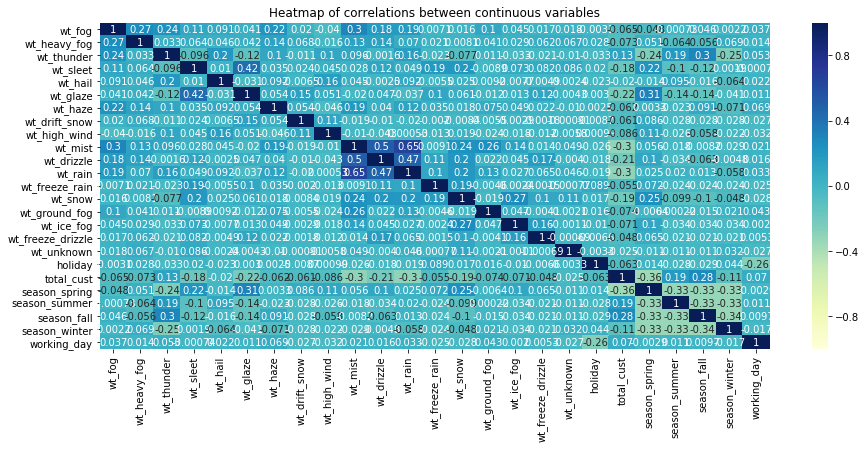

In [22]:
# create a correlation matrix
bike_df_corr_cat = total_bike_df.drop(columns=['date_datetime', 'weekday', 'temp_min', 'temp_max',
                                         'temp_observ', 'precip', 'wind'], axis=1)
bike_df_corr_cat = bike_df_corr_cat.corr(method='kendall')

# create a heatmap to visualize the results
plt.figure(figsize=[15,6])
sb.heatmap(bike_df_corr_cat, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


##### Season

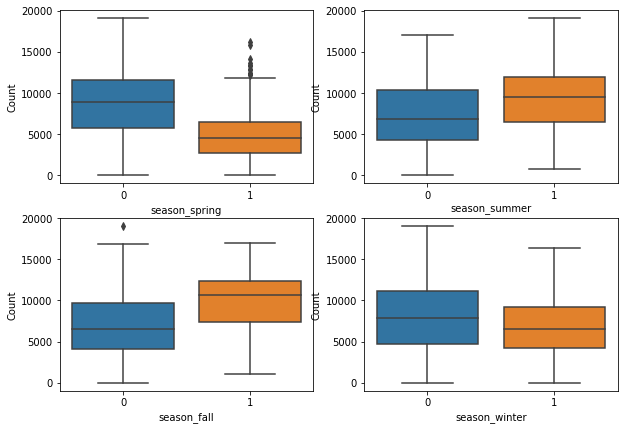

In [23]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall', 'season_winter']

# plotting the seasons vs. number of users in a boxplot
fig, ax = plt.subplots(2, 2, figsize = [10, 7])

count = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 1 and i == 2:
            break
        else:
            ax[j][i] = sb.boxplot(data = total_bike_df, x = season_names[count], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Count')
            ax[j][i].set_xlabel(season_names[count])
            
        count += 1


The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

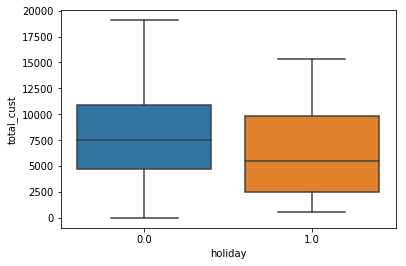

In [24]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = total_bike_df, x = 'holiday', y = 'total_cust');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [25]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(total_bike_df['holiday'], total_bike_df['total_cust'])


KruskalResult(statistic=4918.64868246719, pvalue=0.0)

##### weekday

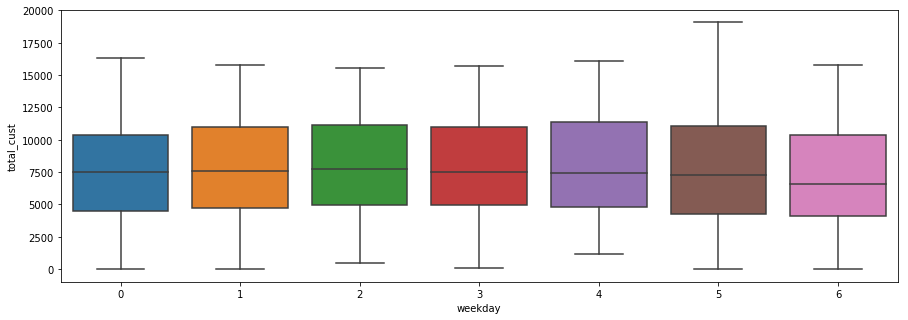

In [26]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = total_bike_df, x = 'weekday', y = 'total_cust');


In [27]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(total_bike_df['weekday'], total_bike_df['total_cust'])


(-0.024775740308038696, 0.18060382477136114)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand. But I still need to onehot encode the weekday because it is a categorical feature.

##### workingday

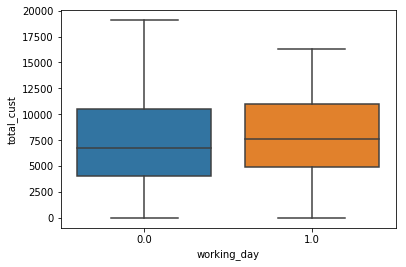

In [28]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = total_bike_df, x = 'working_day', y = 'total_cust');


In [29]:
# Correlation between working_day feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(total_bike_df['working_day'], total_bike_df['total_cust'])


KruskalResult(statistic=4558.474360432267, pvalue=0.0)

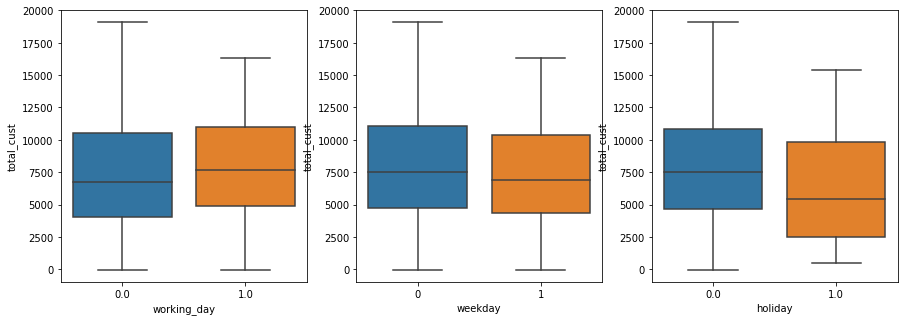

In [30]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = total_bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = total_bike_df, x = 'working_day', y = 'total_cust');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'total_cust');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = total_bike_df, x = 'holiday', y = 'total_cust');


In [31]:
# plot the means of each instance of workingday
total_bike_df.groupby('working_day')['total_cust'].mean()


working_day
0.0    7265.417749
1.0    7906.694695
Name: total_cust, dtype: float64

In [32]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['total_cust'].mean()


weekday
0    7864.162512
1    7304.041866
Name: total_cust, dtype: float64

In [33]:
# plot the means of each instance of holiday
total_bike_df.groupby('holiday')['total_cust'].mean()


holiday
0.0    7755.849276
1.0    6050.573034
Name: total_cust, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable total_cust. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weather type features wt

The wt_ features contain the following features and meanings:
- wt_fog: fog, ice fog, or freezing fog (may include heavy fog)
- wt_heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
- wt_thunder: thunder
- wt_sleet: ice pellets, sleet, snow pellets, or small hail
- wt_hail: hail (may include small hail)
- wt_glaze: glaze or rime
- wt_haze: smoke or haze
- wt_drift_snow: blowing or drifting snow 
- wt_high_wind: high or damaging winds
- wt_mist: mist
- wt_drizzle: drizzle
- wt_rain: rain (may include freezing rain, drizzle, and freezing drizzle)
- wt_freeze_rain: freezing rain
- wt_snow: snow, snow pellets, snow grains, or ice crystals
- wt_ground_fog: ground fog
- wt_ice_fog: ice for or freezing fog
- wt_freeze_drizzle: freezing drizzle
- wt_unknown: unknown source of precipitation

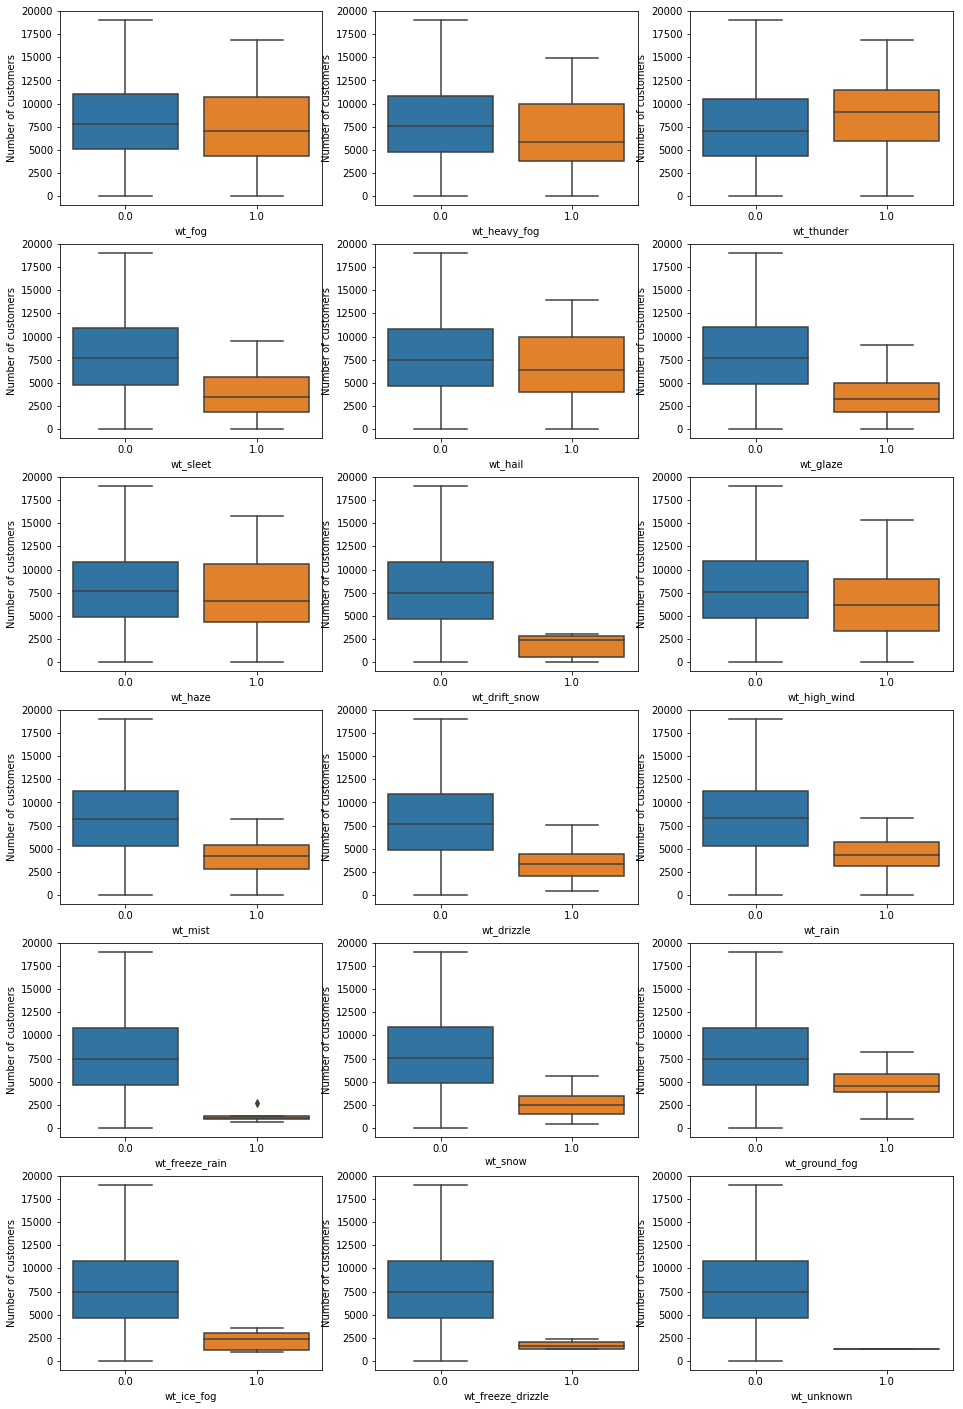

In [34]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(6, 3, figsize = [16, 25])

# create list with all feature names 
wt_feat_list = [x for x in total_bike_df.columns if 'wt_' in x]

# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 5 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = total_bike_df, x = wt_feat_list[counter], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers')
            ax[j][i].set_xlabel(wt_feat_list[counter])
            counter += 1
            

As expected, the weathersit feature has a strong influence on the number of customers. 

#### Continuous variables

granger causality
lagged data

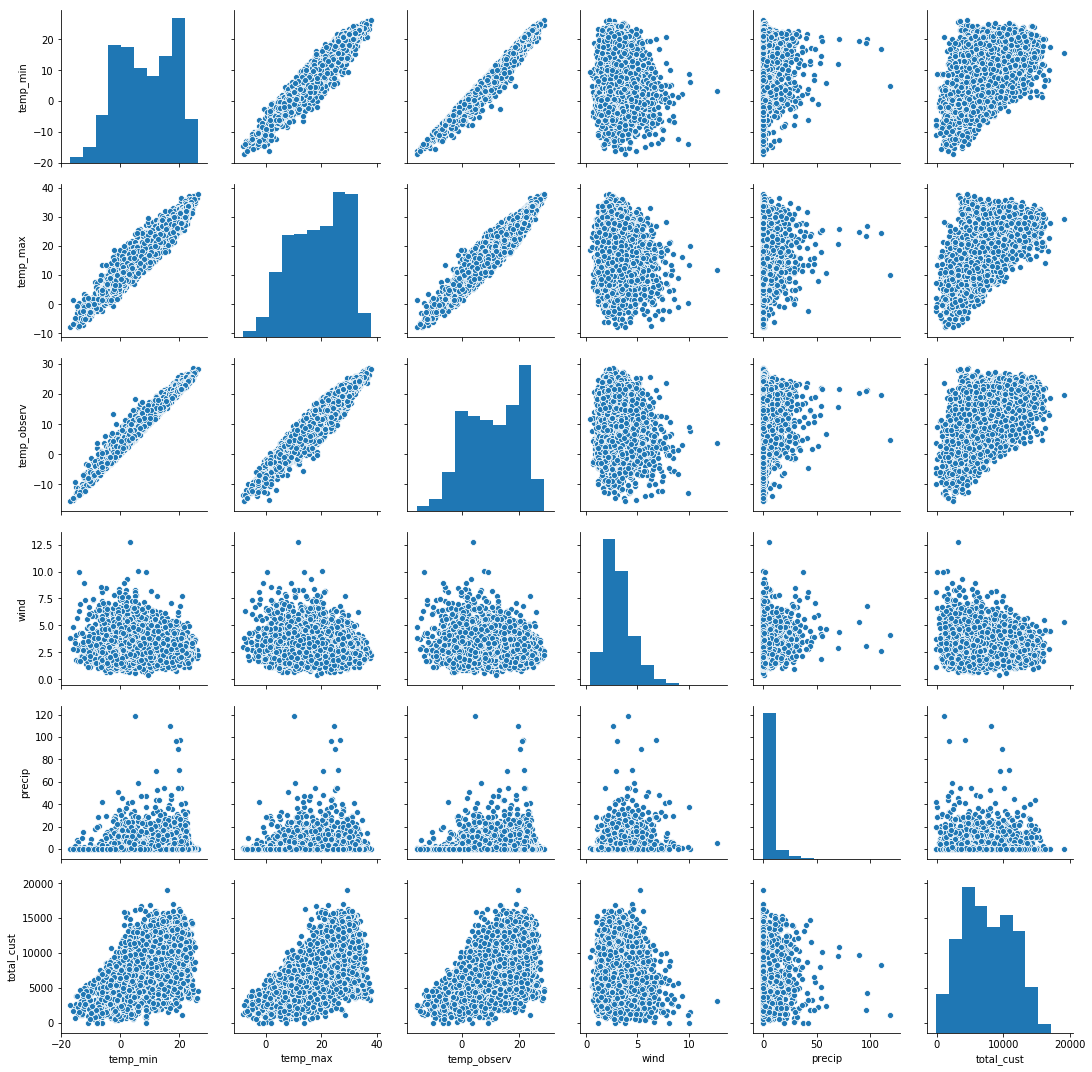

In [35]:
# plot all distributions and scatterplot between each continuous variable pair
sb.pairplot(total_bike_df, vars=['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']);


Based on the results of the above pairplot, the following things are apparent:
* **wind looks like a Weibull distribution**
* there are almost **perfect linear relationships among the four temp features**
* **precip feature is left skewed**
* there is **no linear relationship between precip and any other feature**
* **wind** has **no linear relationship with any other feature**
* the **temp features** have a **medium strong linear relationship with the total_cust target label*



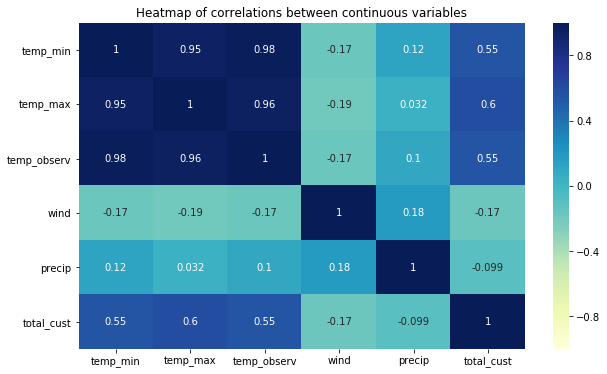

In [36]:
# create a correlation matrix
bike_df_corr = total_bike_df[['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


The heatmap underlines the indications of the pairplot and a number of steps need to be taken:
* the temp features are highly correlated with each other, thus, two of the remaining three features need to be removed. Looking at the individual correlations with the total_cust target label, I will keep the temp_max feature.
* there are only low to very low negative correlations between wind and precip with the target label, respectively. However, I will keep both features in my model.


##### total_cust

C:\Users\julia\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


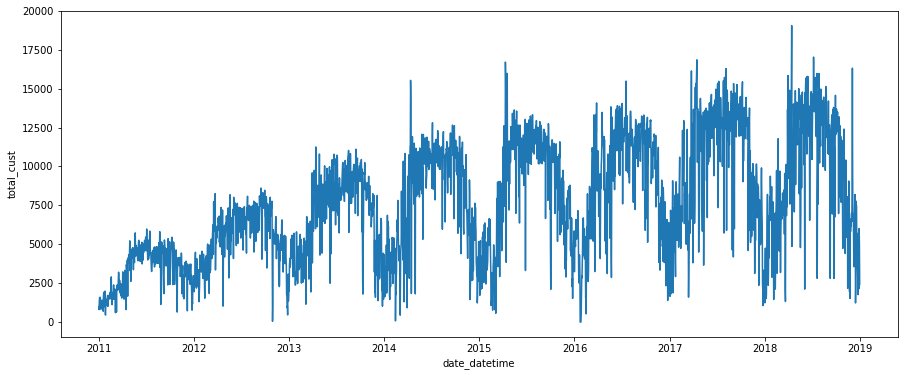

In [37]:
# plot the overall total_cust values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=total_bike_df)


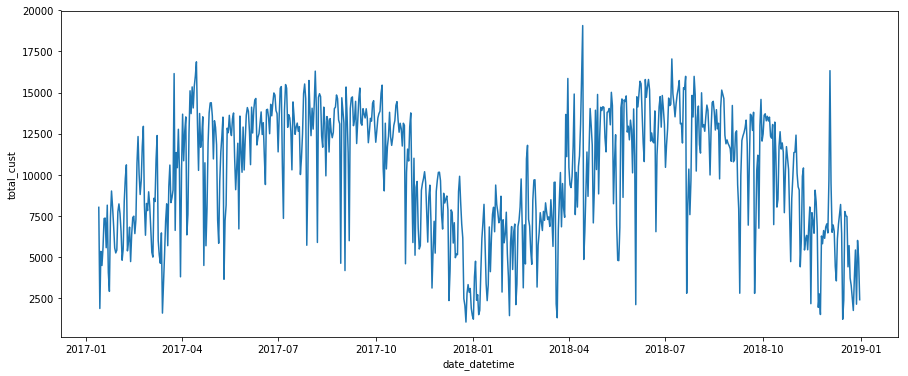

In [38]:
# plot only last two years of timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=total_bike_df[-718:])


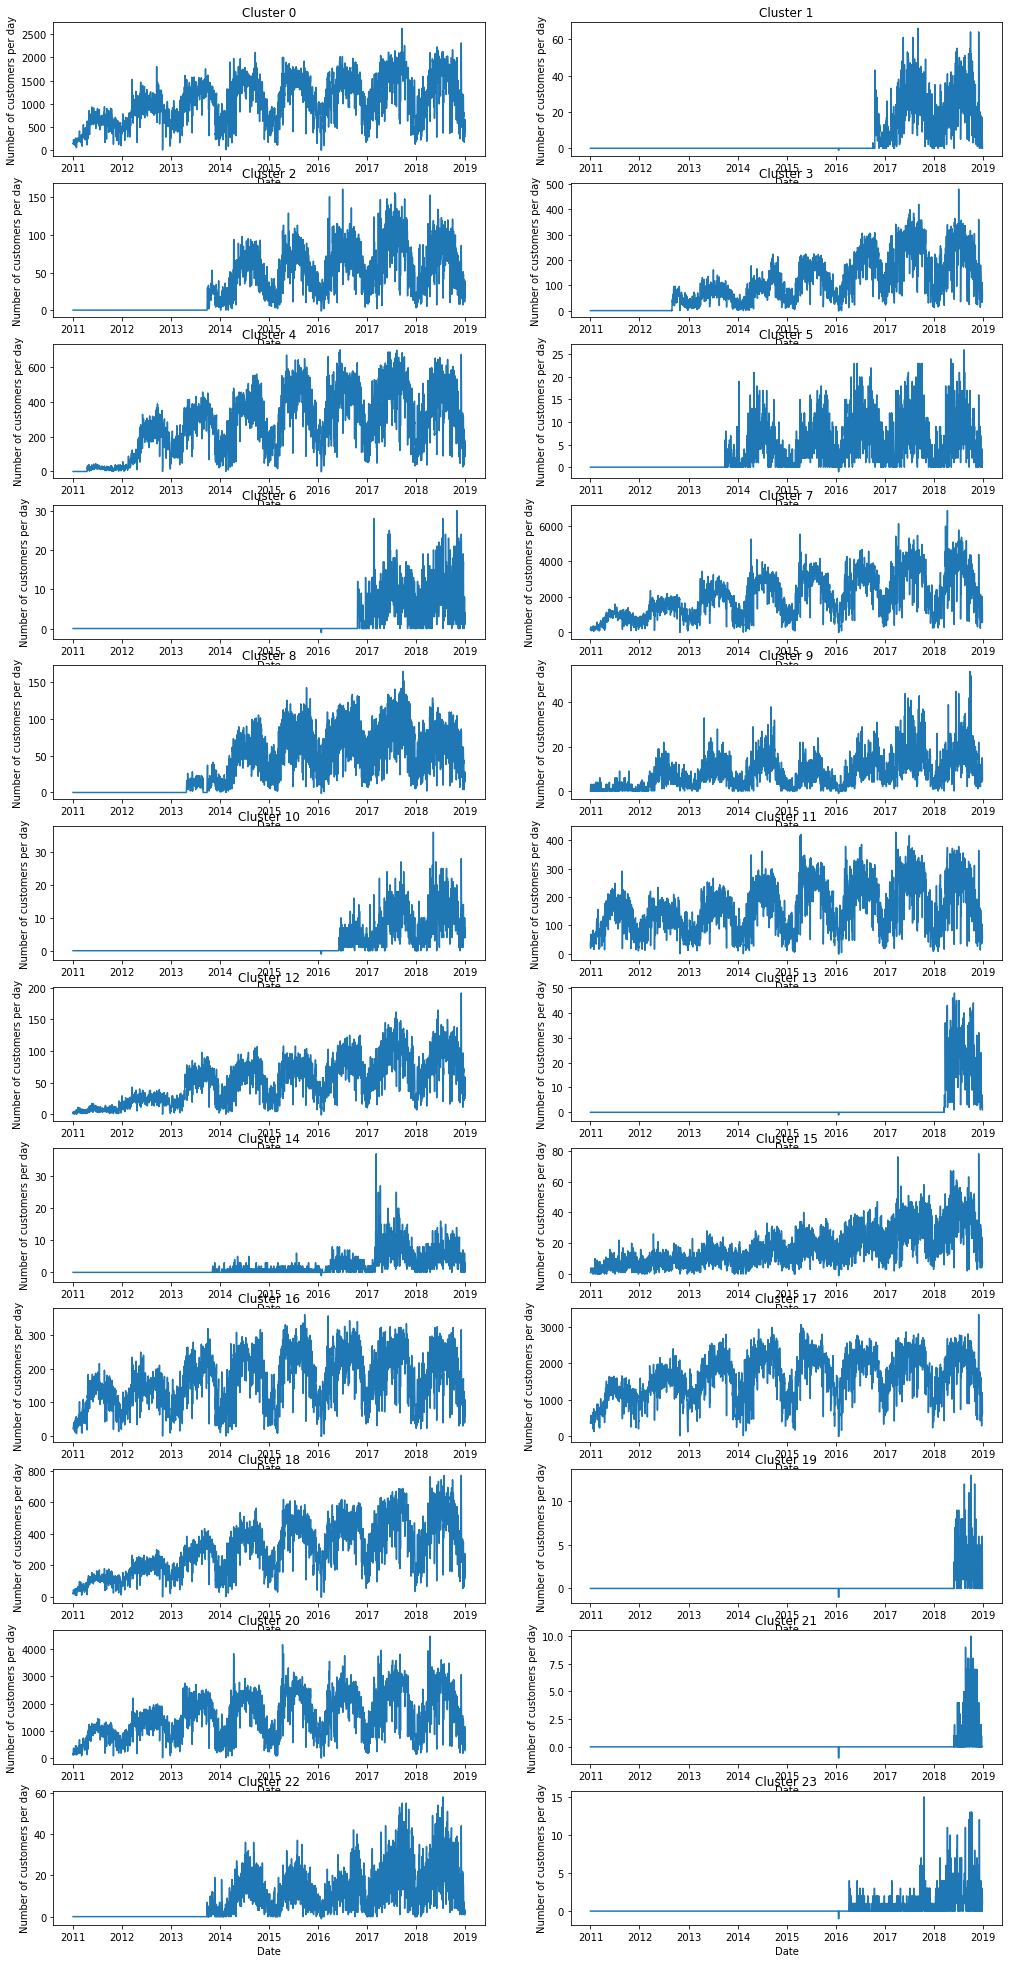

In [39]:
# plotting all total_cust values across the entire timeseries for each cluster
fig, ax = plt.subplots(12, 2, figsize = [17, 35])

# counter for cluster
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 11 and i == 2:
            break
        else:
            ax[j][i] = sb.lineplot(data = all_clusters_dict[counter], x = 'date_datetime', y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers per day')
            ax[j][i].set_xlabel('Date')
            ax[j][i].set_title('Cluster {}'.format(counter))
            counter += 1
            


As can be seen from the graphs above, 13 of the total 26 clusters only had bike stations some time after 2011.

##### temp_max

In [40]:
# create series that group the mean temperature per season
temp_spring = total_bike_df.groupby('season_spring')['temp_max'].mean().rename({1: 'Spring'})
temp_summer = total_bike_df.groupby('season_summer')['temp_max'].mean().rename({1: 'Summer'})
temp_fall = total_bike_df.groupby('season_fall')['temp_max'].mean().rename({1: 'Fall'})
temp_winter = total_bike_df.groupby('season_winter')['temp_max'].mean().rename({1: 'Winter'})

# add them to one series and drop the rows with index 0
temp_seasons = temp_spring.append(temp_summer).append(temp_fall).append(temp_winter)
temp_seasons.drop(labels=[0], inplace=True)


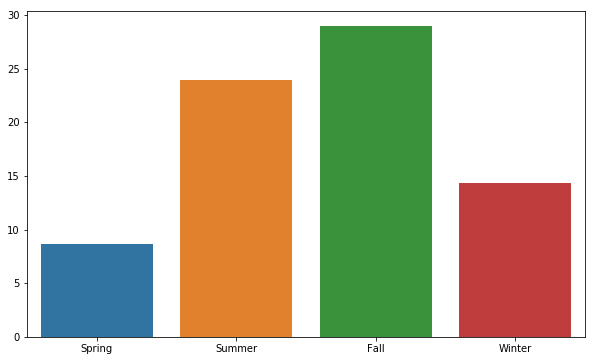

In [41]:
# plot average temp_max per season
plt.figure(figsize=[10,6])
sb.barplot(x=temp_seasons.index, y=temp_seasons.values);


In [42]:
# create series that groups average users per season
cust_spring = total_bike_df.groupby('season_spring')['total_cust'].mean().rename({1: 'Spring'})
cust_summer = total_bike_df.groupby('season_summer')['total_cust'].mean().rename({1: 'Summer'})
cust_fall = total_bike_df.groupby('season_fall')['total_cust'].mean().rename({1: 'Fall'})
cust_winter = total_bike_df.groupby('season_winter')['total_cust'].mean().rename({1: 'Winter'})

# add them to one series and drop the rows with index 0
cust_seasons = cust_spring.append(cust_summer).append(cust_fall).append(cust_winter)
cust_seasons.drop(labels=[0], inplace=True)


<Figure size 1080x504 with 0 Axes>

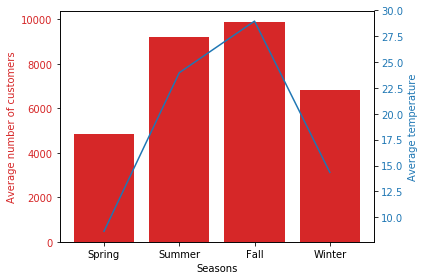

In [43]:
# assign x and y1 and y2
x = list(temp_seasons.index)
y1 = cust_seasons.values
y2 = temp_seasons.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Seasons')
ax1.set_ylabel('Average number of customers', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average temperature', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()


From the above graph we can see that the month variable is correlated with the average number of customers per that month as well as the average temperature. The temperature strongly determines the number of customers. The temperature is likely a very important feature for predicting the target variable.

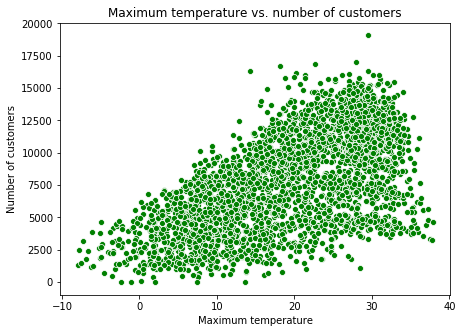

In [44]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[7,5])

sb.scatterplot(data = total_bike_df, x = 'temp_max', y = 'total_cust', color='green')
plt.xlabel('Maximum temperature')
plt.ylabel('Number of customers')
plt.title('Maximum temperature vs. number of customers');



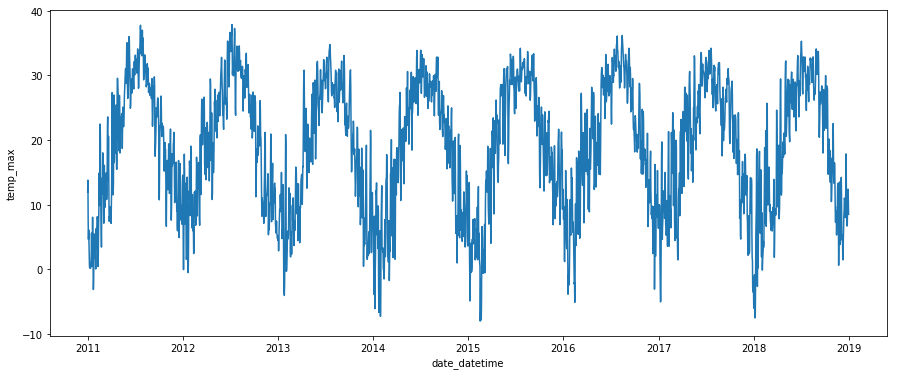

In [45]:
# plot the overall temp_max values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='temp_max', data=total_bike_df)

##### precip

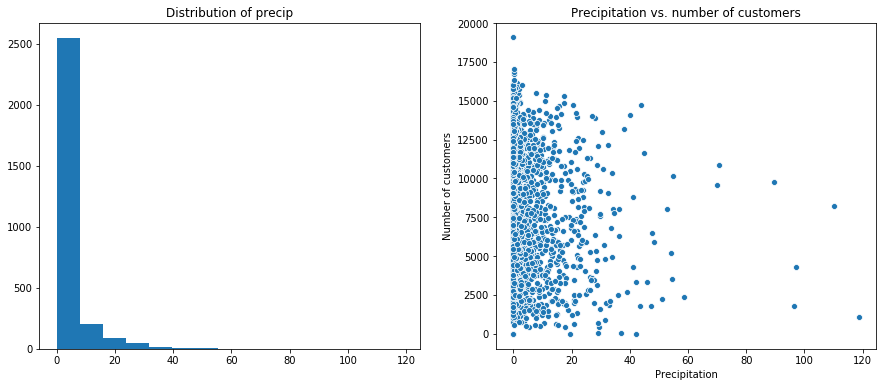

In [46]:
# plotting the distribution of precip
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(total_bike_df['precip'], bins=15)
plt.title('Distribution of precip')

plt.subplot(1,2,2)
sb.scatterplot(data = total_bike_df, x = 'precip', y = 'total_cust')
plt.xlabel('Precipitation')
plt.ylabel('Number of customers')
plt.title('Precipitation vs. number of customers');


Although precip is only correlated with total_cust in a weak sense, I will keep this in the model. This distribution is also left-skewed, so a logarithmic transformation will be necessary.

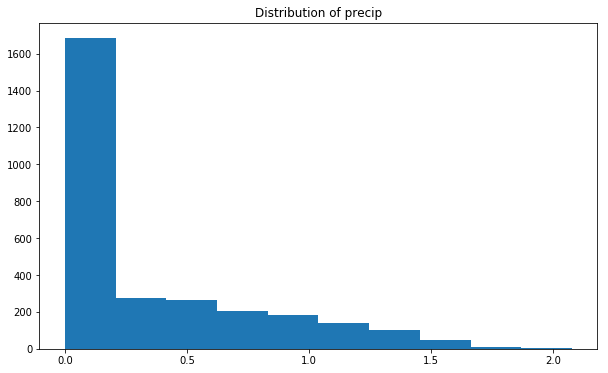

In [47]:
# plotting the distribution of precip
plt.figure(figsize=[10,6])

x = np.log10(total_bike_df['precip'] + 1)
plt.hist(x)
plt.title('Distribution of precip');


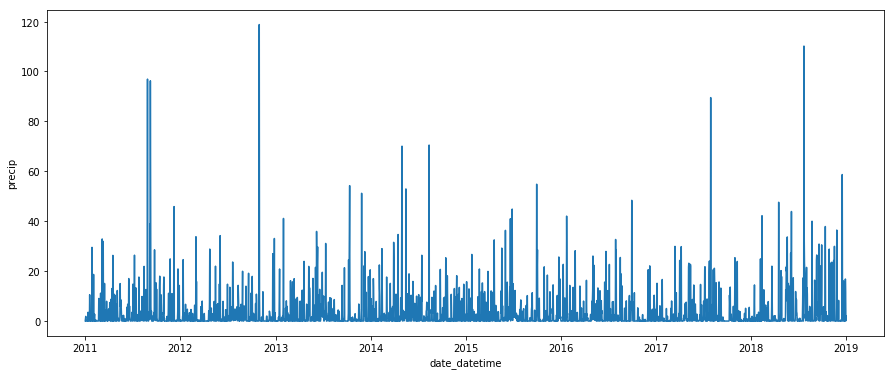

In [48]:
# plot the overall precip values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='precip', data=total_bike_df)


##### wind

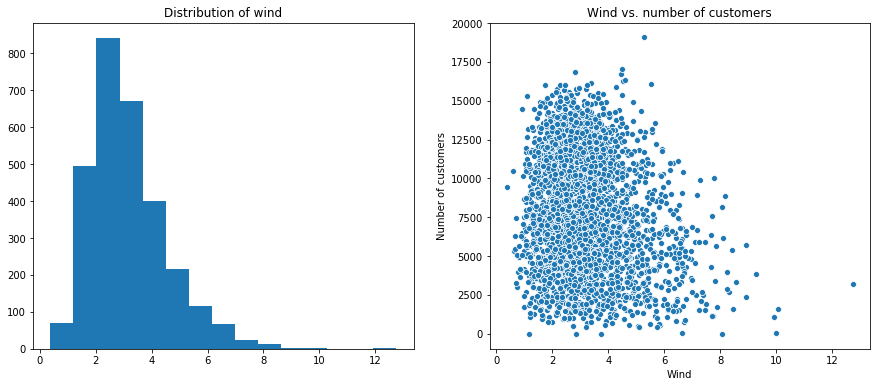

In [49]:
# plotting the distribution of wind
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(total_bike_df['wind'], bins=15)
plt.title('Distribution of wind')

plt.subplot(1,2,2)
sb.scatterplot(data = total_bike_df, x = 'wind', y = 'total_cust')
plt.xlabel('Wind')
plt.ylabel('Number of customers')
plt.title('Wind vs. number of customers');



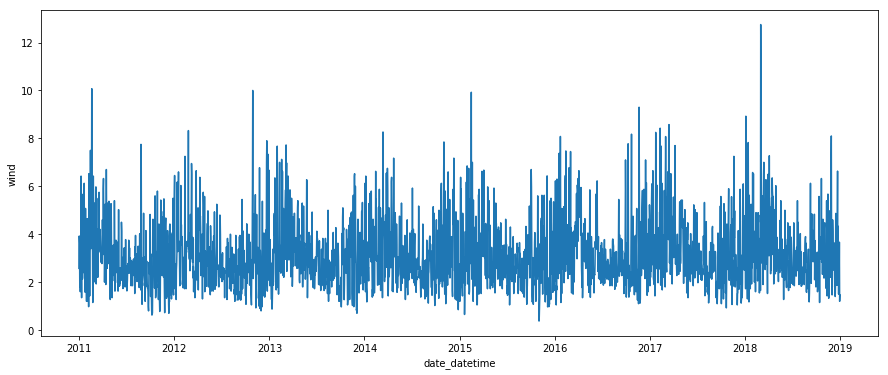

In [50]:
# plot the overall wind values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='wind', data=total_bike_df)


Although windspeed is only correlated with cnt in a weak sense, similar to precip, I will keep this in the model.

#### 2.4. Feature Selection

It is important to avoid look ahead bias and not to consider any features or data that we can only know in the future to predict the future. Checking this bias for all features that are still in the dataset:
* holiday: no lookahead bias
* weekday: no lookahead bias
* workingday: no lookahead bias
* temp_max: temperature has lookahead bias because this is the actually realized temperature on a specific day but when we want to make forecasts, we don't know the temperature that will be realized;
* season_spring: no lookahead bias
* season_summer: no lookahead bias
* season_fall: no lookahead bias
* season_winter: no lookahead bias
* wt_ features: similar to temp_max
* wind: similar to temp_max
* precip: similar to temp_max


### 3. Data Preparation

I am only going to remove any columns which I no longer need and split the dataframes into X and y.

In [51]:
# should keep this before the cleaning function has been created
total_bike_df.drop(columns=['temp_min', 'temp_observ', 'season_winter'], axis=1, inplace=True)

for key, val in all_clusters_dict.items():
    val.drop(columns=['temp_min', 'temp_observ', 'season_winter'], axis=1, inplace=True)


In [52]:
# create dummy variables for weekday in total_bike_df
#weekday_dummies = pd.get_dummies(total_bike_df['weekday'], prefix='weekday', drop_first=True)
#total_bike_df = total_bike_df.join(weekday_dummies, how='left')
#total_bike_df.drop(columns=['weekday'], inplace=True)


In [53]:
# create dummy variables for weekday in each cluster df
#for key, val in all_clusters_dict.items():
#    weekday_dummies_clust = pd.get_dummies(val['weekday'], prefix='weekday', drop_first=True)
#    new_val = val.join(weekday_dummies_clust, how='left')
#    new_val.drop(columns=['weekday'], axis=1, inplace=True)
#    all_clusters_dict[key] = new_val


In [54]:
# splitting total_bike_df into X and y
#y_total = total_bike_df['total_cust']
#X_total = total_bike_df.drop(columns='total_cust')


In [55]:
# splitting all_cluster_dicts into X and y
#y_all_clusters = defaultdict()

#for key, val in all_clusters_dict.items():
    #y_all_clusters[key] = val['total_cust']
    
#X_all_clusters = defaultdict()

#for key, val in all_clusters_dict.items():
    #X_all_clusters[key] = val.drop(columns='total_cust')


In [56]:
# drop the timestamp variable
total_bike_df.drop(columns=['date_datetime'], inplace=True)

for key, val in all_clusters_dict.items():
    val.drop(columns=['date_datetime'], inplace=True)


In [57]:
# creating lag variables
#lag = [x for x in range(1, 8)]

#for col in total_bike_df.columns:
 #   for l in lag:
  #      total_bike_df[col+"_t-"+str(l)] = total_bike_df[col].shift(l)


In [58]:
# drop the values at time t from the dataframe
#total_bike_df_7_lag = total_bike_df.drop(columns=total_bike_df.columns[:32])
#total_bike_df_7_lag = total_bike_df.loc[7:]
#total_bike_df_7_lag.reset_index(drop=True, inplace=True)
#total_bike_df_7_lag


In [59]:
y = total_bike_df['total_cust']
X = total_bike_df.drop(columns=['total_cust'])


In [60]:
# defining the hyperparameters
hyperparams = {
    'n_estimators': 4, 'criterion': 'mse', 'max_depth': None, 'min_samples_split': 2, 
    'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 
    'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 
    'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 1909, 
    'verbose': 0, 'warm_start': False}

# initializing the model which is a Stochastic Gradient Descent model
model = RandomForestRegressor(**hyperparams)


In [180]:
# creating a class to add lagged variables to dataframe
class LagVars(BaseEstimator, TransformerMixin):

    def __init__(self, lag=7):
        self.lag = lag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df = pd.DataFrame(df)
        col_num = df.shape[1]
        list_lags = [x for x in range(1,self.lag+1)]
        
        for item in range(col_num):
            for num in list_lags:
                df[str(item)+'_t-'+str(num)] = df.iloc[:,item].shift(num)
        
        df_new = df.fillna(0)
        #df_new = df[self.lag:]

        # removing the variables at time t
        df_final = df_new.iloc[:,col_num:]         

        
        return df_final
    

In [181]:
class Debug(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        self.shape = X.shape
        print(self.shape)
        print(X)
        # what other output you want
        return X

In [182]:
columns_scaler = ['temp_max', 'precip', 'wind']

categorical_transformer = Pipeline([
    ('onehotencoder', OneHotEncoder(categories='auto')),
])

preprocessor = ColumnTransformer([
    ('categorical_transformer', categorical_transformer, ['weekday']),
    ('scaler', MinMaxScaler(), list(columns_scaler))
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lagged_vars', LagVars()),
    #('debug', Debug()),
    ('model', model)
])

In [183]:
pipeline_df = pipeline.fit(X, y)


In [190]:
time_split = TimeSeriesSplit(n_splits=30)

cv = cross_val_score(pipeline, X, y, cv=time_split, 
                            scoring='neg_mean_squared_error', n_jobs=1)


In [191]:
rmse = [np.sqrt(-1 * x) for x in cv]
rmse

[2097.355018066448,
 1283.0679792959845,
 1242.64848474898,
 2532.068937001661,
 2435.332682666982,
 2529.8614687758713,
 2349.429509748398,
 2949.3698441181664,
 2752.215064628505,
 2730.7476447793715,
 2650.688241116964,
 3046.6346332356384,
 2741.151952967095,
 2696.7614498049797,
 2317.6690863917474,
 3424.2906197737093,
 3061.0527579089726,
 2658.9206945626274,
 2633.6961846585696,
 3205.481181723421,
 3185.164855740544,
 3051.205830151766,
 3059.4987384513015,
 3770.069094423698,
 4087.5388696993687,
 3639.097311881855,
 2766.374492324189,
 4165.789121162362,
 3288.0894474999673,
 3231.29161697962]

In [ ]:
# stationarity handling?
# how to split the data in rolling window approach and use the prediction pipeline

### 4. Model

Be careful --> this is time series data so I need to be careful when splitting the dataset

I may not need to split it when using pipelines, but I need to research how to do this

My pipeline should include ALL transformations, including onehot encoding, that I make after the very initial cleaning of data. Thus, I need to read in my data again after the EDA process.

If I'm using gradient descent I most DEFINITELY need to convert month and year to categorical features

my model needs to use the cnt of today and check how the weather of the previous week predicted cnt

or I could use the forecast of today and see how the forecast predicted the cnt

day 1 day 2 day 3 day 4 day 5 day 6 day 7 --> predict cnt of day 8

look at the mean and standard deviation of the 


#### 4.1. Random Forests

In [ ]:
# defining the hyperparameters
hyperparams = {
    'n_estimators': 4, 'criterion': 'mse', 'max_depth': None, 'min_samples_split': 2, 
    'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 
    'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 
    'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 1909, 
    'verbose': 0, 'warm_start': False}

# initializing the model which is a Stochastic Gradient Descent model
model = RandomForestRegressor(**hyperparams)


#### 4.2. XGBoost

#### 4.3. AdaBoost

#### 4.4. LightGBM

### 5. Evaluation